# Marrying Grounding DINO with GLIGEN for Image Editing


[![Grounding DINO](https://badges.aleen42.com/src/github.svg)](https://github.com/IDEA-Research/GroundingDINO)
[![GLIGEN](https://badges.aleen42.com/src/github.svg)](https://github.com/gligen/GLIGEN)


[![arXiv](https://img.shields.io/badge/arXiv-2303.05499-b31b1b.svg)](https://arxiv.org/abs/2303.05499) 
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/wxWDt5UiwY8)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-grounding-dino.ipynb)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/cMa77r3YrDk)
[![HuggingFace space](https://img.shields.io/badge/🤗-HuggingFace%20Space-cyan.svg)](https://huggingface.co/spaces/ShilongLiu/Grounding_DINO_demo)

![gdgligen](https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/GD_GLIGEN.png)

# Build environment

**GLIGEN uses a modified diffusers. We highly recommoned to use new conda virtural environment for the notebook!**

To do this, please run the following commands and rerun the notebook with the new environment:

```bash
conda create -n gligen_diffusers python=3.10
conda activate gligen_diffusers
```

In [50]:
! pip install diffusers transformers accelerate scipy safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
# install gligen_diffusers
! pwd
! git clone git@github.com:gligen/diffusers.git
! python -m pip install -e diffusers

/home/liushilong/code/groundingDINO_github/demo
fatal: destination path 'diffusers' already exists and is not an empty directory.
Obtaining file:///home/liushilong/code/groundingDINO_github/demo/diffusers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.15.0.dev0-0.editable-py3-none-any.whl size=11144 sha256=9fe81ae4227df8b6e117161b35214dcea3f0a416d7833a14dc288d82cd655e78
  Stored in directory: /tmp/pip-ephem-wheel-cache-_gavg55g/wheels/72/c9/f3/415f9981a289ad0e26f1f6be84a2e461090bce24395f25d065
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.15.0.dev0
    Uninstalling diffusers-0.15.0.dev0:
      Successfully uninstalled diffusers-0.15.0.dev0


In [2]:
import os

# setup device. If you have a GPU, you can change this to "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [68]:
import argparse
from functools import partial
import cv2
import requests

from io import BytesIO
from PIL import Image
import numpy as np
from pathlib import Path
import random


import warnings
warnings.filterwarnings("ignore")


import torch
from torchvision.ops import box_convert

from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from groundingdino.util.inference import annotate, load_image, predict
import groundingdino.datasets.transforms as T

from huggingface_hub import hf_hub_download


# Load grounding dino models

In [4]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model    

In [5]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swint_ogc.pth"
ckpt_config_filename = "GroundingDINO_SwinT_OGC.cfg.py"

In [6]:
model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /home/liushilong/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/d6b1ecf62f56b2affe410ed025352a07b57d4661/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


# Load GLIGEN inpainting models

In [7]:
from diffusers import StableDiffusionGLIGENPipeline


pipe = StableDiffusionGLIGENPipeline.from_pretrained("gligen/diffusers-inpainting-text-box", revision="fp16", torch_dtype=torch.float16)
pipe.to("cuda")

safety_checker/model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionGLIGENPipeline {
  "_class_name": "StableDiffusionGLIGENPipeline",
  "_diffusers_version": "0.15.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

# Load demo image

In [202]:
image_url = 'https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/art_dog_birthdaycake.png'
local_image_path = 'art_dog_birthdaycake.png'

In [203]:
import io


def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

download_image(image_url, local_image_path)

Image downloaded from url: https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/art_dog_birthdaycake.png and saved to: art_dog_birthdaycake.png.


# Run Grounding DINO

In [204]:
import os
import supervision as sv


TEXT_PROMPT = "dog. cake."
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(local_image_path)

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

# image_source: np.ndarray
# annotated_frame: np.ndarray

In [205]:
def generate_masks_with_grounding(image_source, boxes):
    h, w, _ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
    boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    mask = np.zeros_like(image_source)
    for box in boxes_xyxy:
        x0, y0, x1, y1 = box
        mask[int(y0):int(y1), int(x0):int(x1), :] = 255
    return mask

In [206]:
image_mask = generate_masks_with_grounding(image_source, boxes)

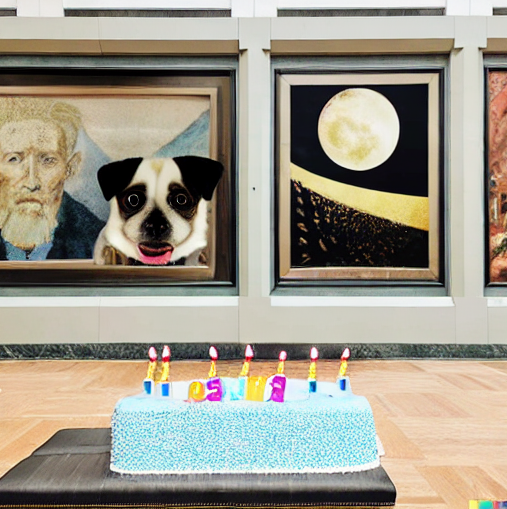

In [207]:
Image.fromarray(image_source)

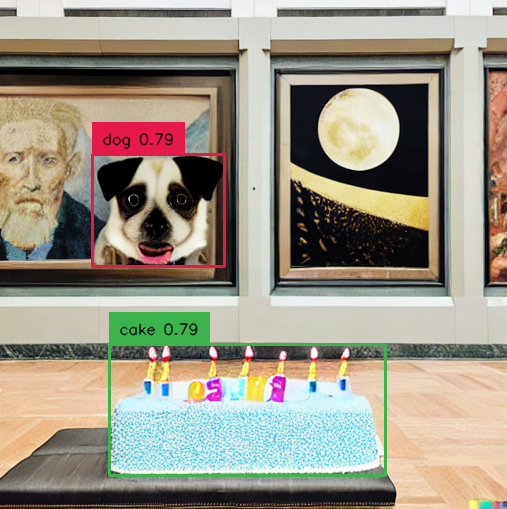

In [208]:
Image.fromarray(annotated_frame)

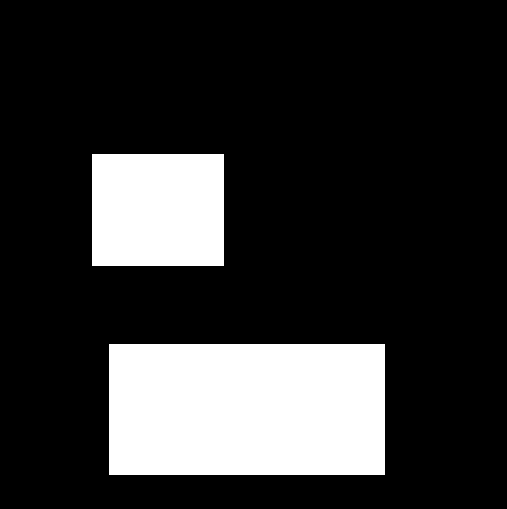

In [209]:
Image.fromarray(image_mask)

# Image Inpainting

In [210]:
image_source = Image.fromarray(image_source)
annotated_frame = Image.fromarray(annotated_frame)
image_mask = Image.fromarray(image_mask)

In [211]:
image_source_for_inpaint = image_source.resize((512, 512))
image_mask_for_inpaint = image_mask.resize((512, 512))

In [212]:
num_box = len(boxes)
num_box

2

In [213]:
xyxy_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").tolist()
xyxy_boxes[:2]

[[0.18195317685604095,
  0.3042256236076355,
  0.4422861933708191,
  0.5236865282058716],
 [0.21554315090179443,
  0.6760779619216919,
  0.7596603631973267,
  0.934249758720398]]

In [214]:
# define prompts for each box
gligen_phrases = ['a cat', 'a rose']

In [215]:
prompt = "'a cat', 'a rose'"

num_box = len(boxes)

image_inpainting = pipe(
    prompt,
    num_images_per_prompt = 2,
    gligen_phrases = gligen_phrases,
    gligen_inpaint_image = image_source_for_inpaint,
    gligen_boxes = xyxy_boxes,
    gligen_scheduled_sampling_beta=1,
    output_type="numpy",
    num_inference_steps=50
).images

100%|██████████| 50/50 [00:08<00:00,  5.95it/s]


In [216]:
# 0..1 to 0..255, and convert to uint8
image_inpainting = (image_inpainting * 255).astype(np.uint8)

In [220]:
image_inpainting = np.concatenate(image_inpainting, axis=1)

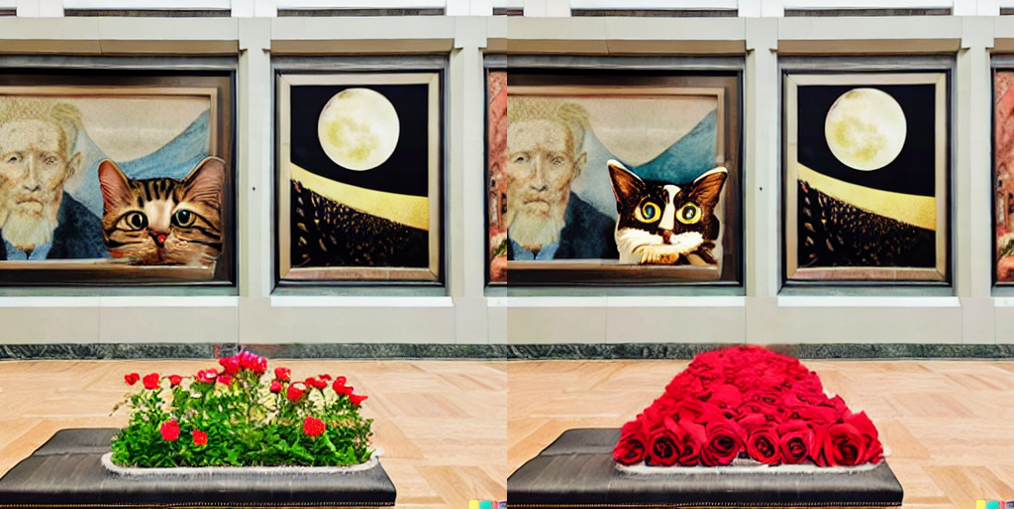

In [223]:
Image.fromarray(image_inpainting).resize((image_source.size[0]*2, image_source.size[1]))